# Seminar 2. Latent Variable Models

- **VAEs on 2D Data (5 points)**
- **VAEs on images (5 points)**
- VQ-VAE on images (20 points)
- \*Bonus

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part 1: VAEs on 2D Data (5 points)
Here we will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Data
We will use 4 datasets, each sampled from some gaussian.

In [9]:
def sample_data_1_a(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_data_2_a(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + (rand.randn(count, 2) * [[1.0, 5.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])


def sample_data_1_b(count):
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2_b(count):
    rand = np.random.RandomState(0)
    return [[-1.0, 2.0]] + rand.randn(count, 2) * [[1.0, 5.0]]


def q1_sample_data(part, dset_id):
    assert dset_id in [1, 2]
    assert part in ['a', 'b']
    if part == 'a':
        if dset_id == 1:
            dset_fn = sample_data_1_a
        else:
            dset_fn = sample_data_2_a
    else:
        if dset_id == 1:
            dset_fn = sample_data_1_b
        else:
            dset_fn = sample_data_2_b

    train_data, test_data = dset_fn(10000), dset_fn(2500)
    return train_data.astype('float32'), test_data.astype('float32')


def visualize_q1_data(part, dset_id):
    train_data, test_data = q1_sample_data(part, dset_id)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('Train Data')
    ax1.scatter(train_data[:, 0], train_data[:, 1])
    ax2.set_title('Test Data')
    ax2.scatter(test_data[:, 0], test_data[:, 1])
    print(f'Dataset {dset_id}{part}')
    plt.show()

Dataset 1a


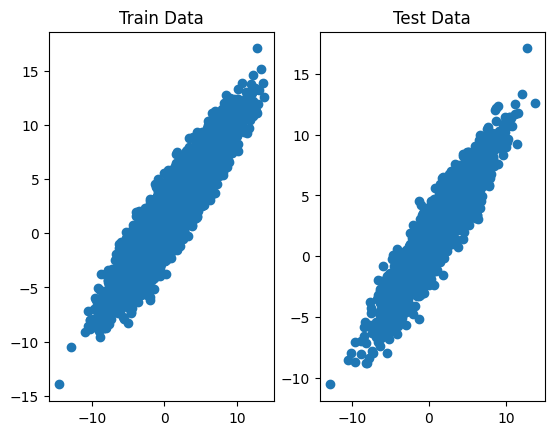

Dataset 2a


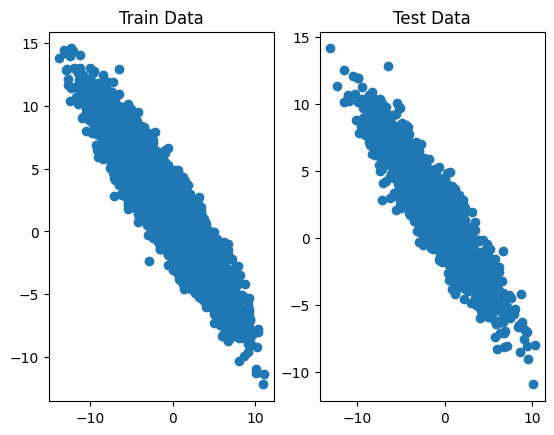

Dataset 1b


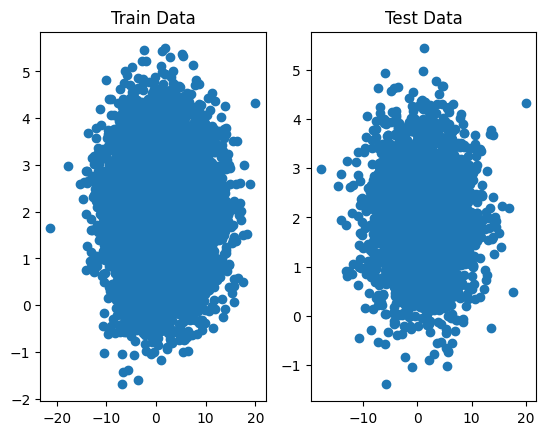

Dataset 2b


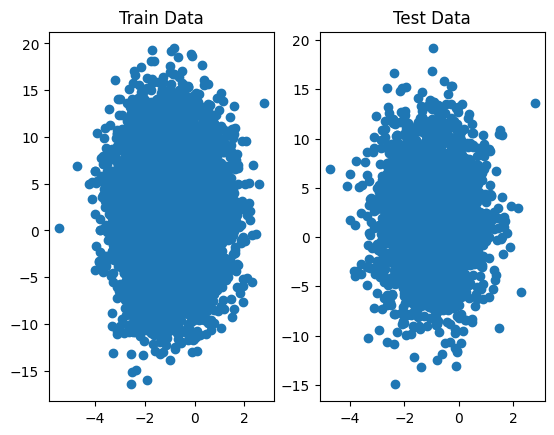

In [10]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

Construct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise

## Solution
Fill out the functions below, create additional classes/functions/cells if needed

In [11]:
from collections import OrderedDict, defaultdict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

In [21]:
class VAEModel(nn.Module):
    def loss(self, x):
        """
        returns dict with losses (loss_name -> loss_value)
        """
        pass

    def sample(self, n, noise=True):
        """
        returns numpy array of n sampled points, shape=(n, 2)
        """
        pass


class VAEMapper(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        self.net = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hidden_dim),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dim, out_features=2*out_dim),
        )

    def forward(self, x):
        y = self.net(x)
        mu, log_sigma = y[:, :self.out_dim], y[:, self.out_dim:]

        return mu, log_sigma


class FullyConnectedVAE(VAEModel):
    def __init__(self, x_dim, hidden_dim, z_dim, device):
        super().__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        self.encoder = VAEMapper(in_dim=x_dim, hidden_dim=hidden_dim, out_dim=z_dim)
        self.decoder = VAEMapper(in_dim=z_dim, hidden_dim=hidden_dim, out_dim=x_dim)

        self.device = device
        self.to(device)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x)
        z = torch.randn(mu_z.size(), device=self.device) * torch.exp(log_std_z * 0.5) + mu_z
        mu_x, log_std_x = self.decoder(z)

        # Compute reconstruction loss
        recon_loss = 0.5 * (log_std_x + (x - mu_x) ** 2 * torch.exp(-log_std_x)).sum(1).mean(0)

        # Compute KL
        kl_loss = -0.5 * (1 + log_std_z - mu_z ** 2 - torch.exp(log_std_z)).sum(1).mean(0)

        loss = recon_loss + kl_loss
        return {"loss": loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

    @torch.no_grad()
    def sample(self, n, noise=True):
        z = torch.randn((n, self.x_dim), device=self.device)
        mu_x, log_std_x = self.decoder(z)
        if noise:
            result = torch.randn(mu_x.size(), device=self.device) * torch.exp(log_std_x * 0.5) + mu_x
        else:
            result = mu_x

        return result.cpu().numpy()


def train_epoch(model, train_loader, optimizer, epoch, grad_clip=None):
    """
    train model on loader for single epoch
    returns Dict[str, List[float]] - dict of losses on each training batch
    """
    model.train()

    losses = defaultdict(list)
    
    for x in train_loader:
        x = x.to(model.device)
        l = model.loss(x)
        optimizer.zero_grad()
        l['loss'].backward()
        optimizer.step()

        for loss_name, loss_value in l.items():
            losses[loss_name].append(loss_value.item())

    return losses


def valid_epoch(model, data_loader):
    """
    evaluates model on dataset
    returns Dict[str, float] - dict with average losses on entire dataset
    """
    model.eval()
    average_losses = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            x = x.to(model.device)
            l = model.loss(x)

            for loss_name, loss_value in l.items():
                average_losses[loss_name] += loss_value.item() * x.shape[0]

    for k in average_losses:
        average_losses[k] /= len(data_loader.dataset)
    return average_losses


def train_loop(model, train_loader, test_loader, epochs=10, lr=1e-3, grad_clip=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = defaultdict(list), defaultdict(list)
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, epoch, grad_clip)
        test_loss = valid_epoch(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

In [22]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    model = FullyConnectedVAE(2, 64, 2, 'cpu')
    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train_loop(model, train_loader, test_loader,
                                           epochs=10, lr=1e-3)
    train_losses = np.stack((train_losses['loss'], train_losses['reconstruction_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['reconstruction_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(1000, noise=True)
    samples_nonoise = model.sample(1000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

Dataset 1a
Final -ELBO: 2.7539, Recon Loss: 1.4482, KL Loss: 1.3058


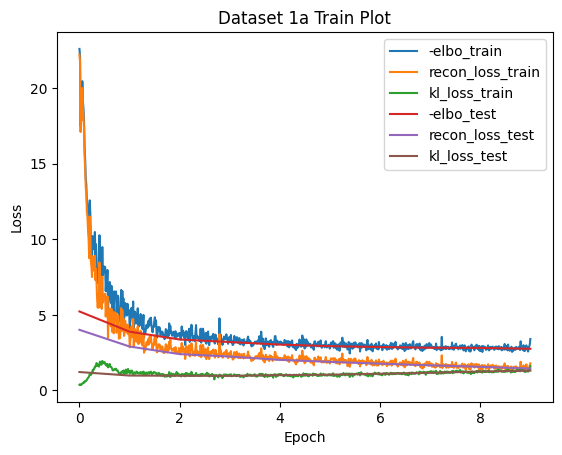

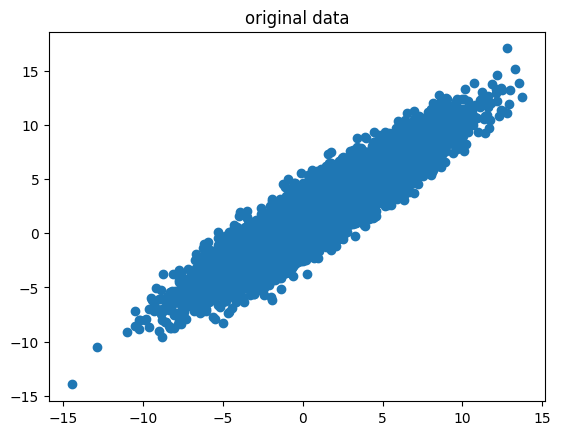

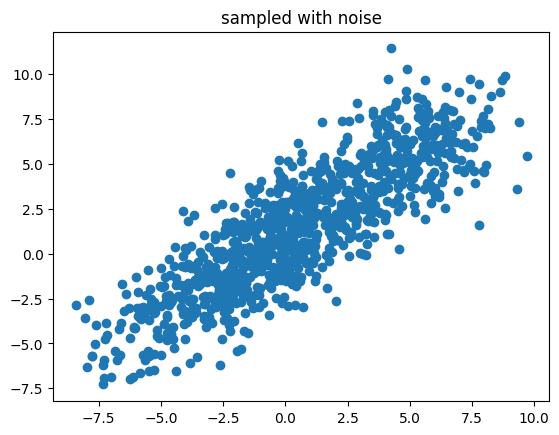

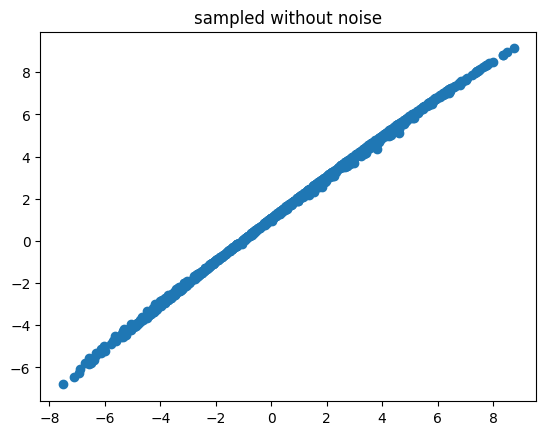

Dataset 2a
Final -ELBO: 2.8715, Recon Loss: 1.8313, KL Loss: 1.0402


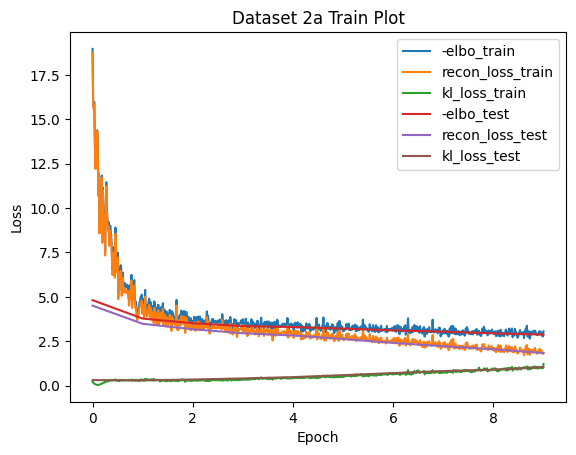

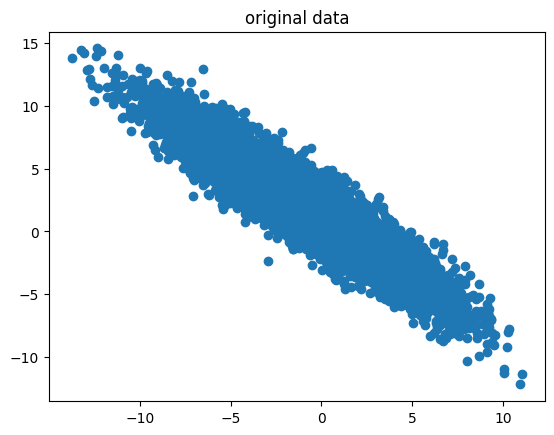

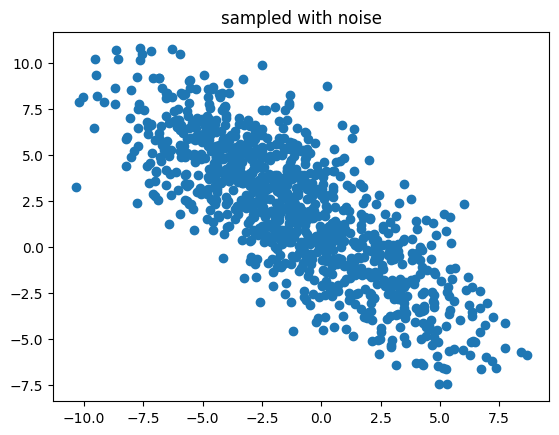

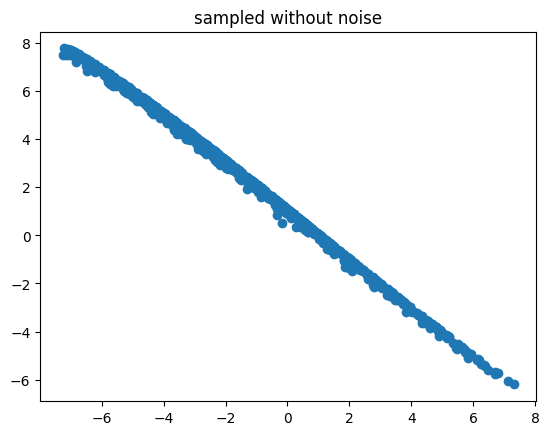

Dataset 1b
Final -ELBO: 2.6055, Recon Loss: 2.5190, KL Loss: 0.0865


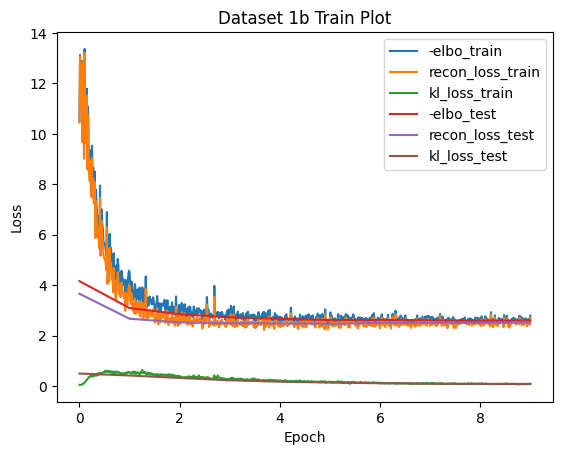

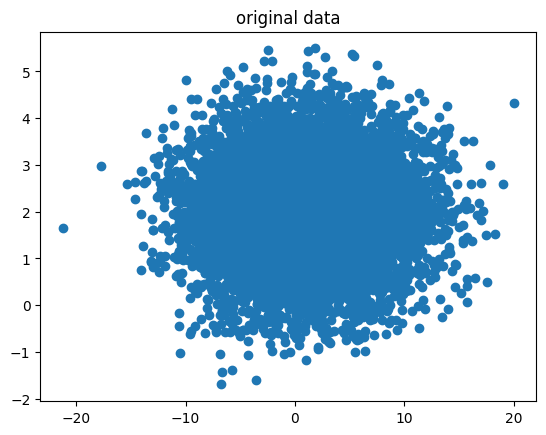

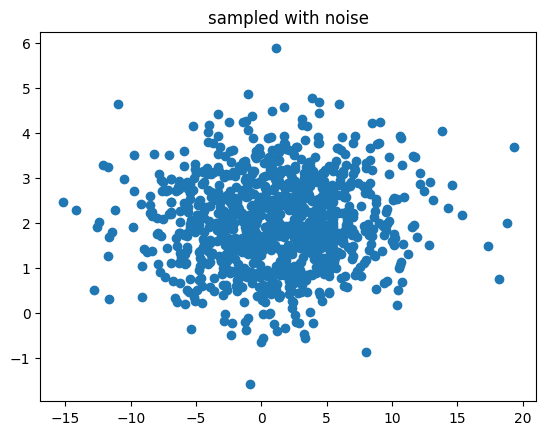

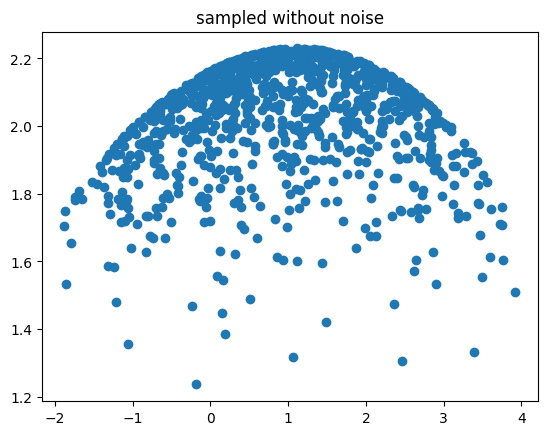

Dataset 2b
Final -ELBO: 2.5981, Recon Loss: 2.4986, KL Loss: 0.0995


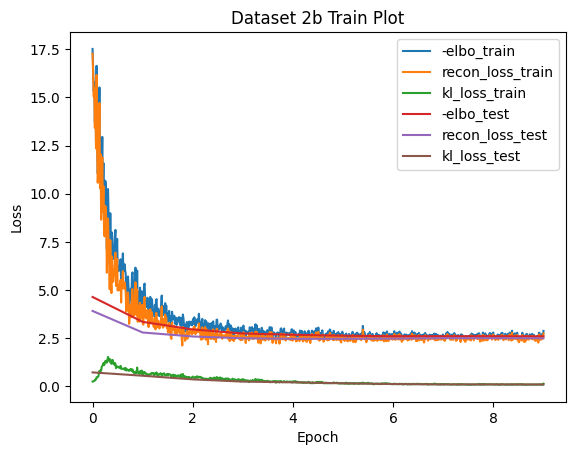

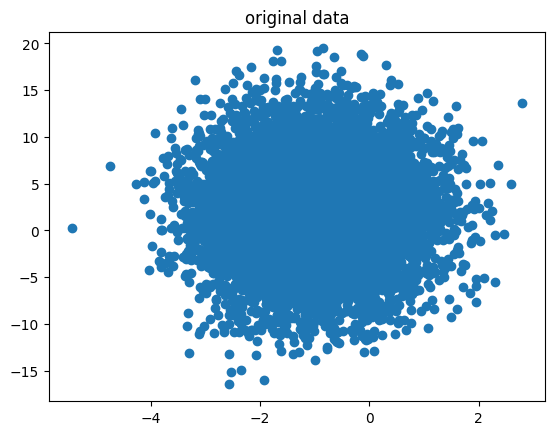

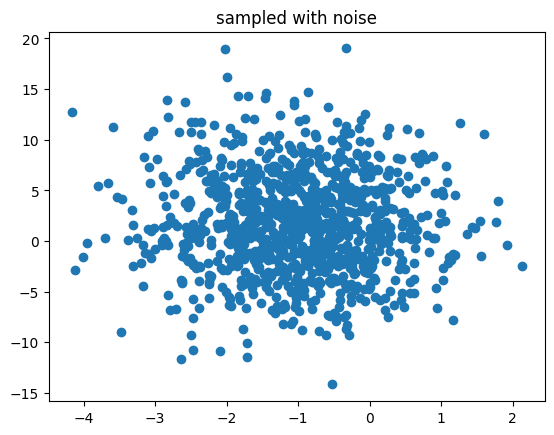

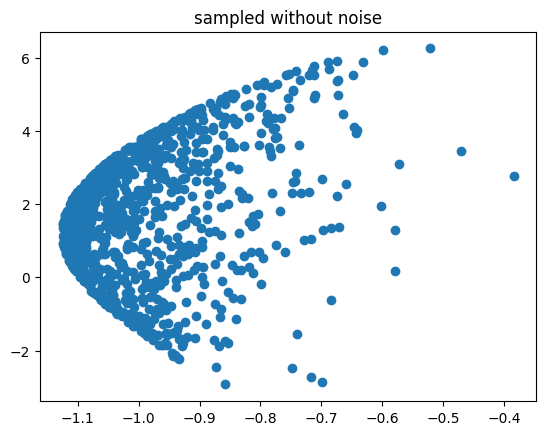

In [23]:
def draw_2d(samples, title):
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.title(title)
    plt.show()

def plot_vae_training_plot(train_losses, test_losses, title):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')

    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def q1_results(part, dset_id, fn):
    print(f"Dataset {dset_id}{part}")
    train_data, test_data = q1_sample_data(part, dset_id)
    train_losses, test_losses, samples_noise, samples_nonoise = fn(train_data, test_data, part, dset_id)
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')
    plot_vae_training_plot(train_losses, test_losses, title=f'Dataset {dset_id}{part} Train Plot')
    draw_2d(train_data, 'original data')
    draw_2d(samples_noise, 'sampled with noise')
    draw_2d(samples_nonoise, 'sampled without noise')
    
q1_results('a', 1, q1)
q1_results('a', 2, q1)
q1_results('b', 1, q1)
q1_results('b', 2, q1)

## Reflection
Compare the sampled xs with and without decoder noise for datasets (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? 

**Write your answer (1-2 sentences):**

# Part 2: VAEs on Images

After the previous exercise you should understand how to train simple VAE. Now let's move from 2D space to more complex image spaces. The training methodology is just the same, the only difference is if we want to have good results we should have better encoder and decoder models.

In this section, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (CIFAR10, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

100%|██████████| 170498071/170498071 [01:38<00:00, 1729595.08it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


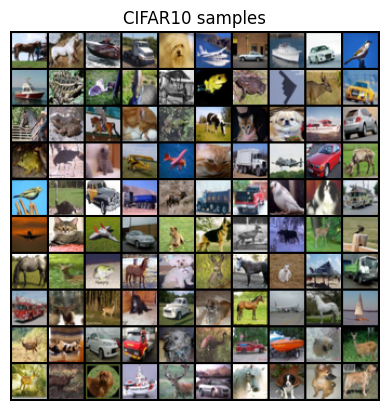

100%|██████████| 182040794/182040794 [01:46<00:00, 1713113.84it/s]


100%|██████████| 64275384/64275384 [00:39<00:00, 1611017.10it/s]


(26032, 32, 32, 3)


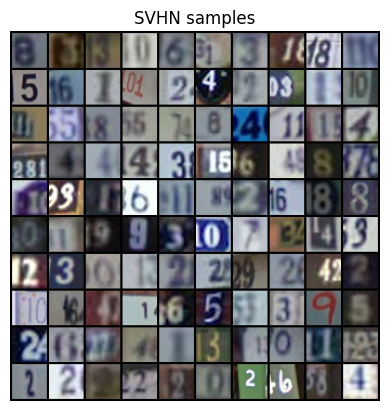

In [24]:
from torchvision.datasets import SVHN, CIFAR10
from torchvision.utils import make_grid
import numpy as np

def show_samples(samples, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


DATA_DIR = './data'
def get_cifar10():
    train = CIFAR10(root=f'{DATA_DIR}/cifar10', train=True, download=True).data
    test = CIFAR10(root=f'{DATA_DIR}/cifar10', train=False).data
    return train, test


def get_svhn():
    train = SVHN(root=f'{DATA_DIR}/svhn', split='train', download=True).data.transpose(0, 2, 3, 1)
    test = SVHN(root=f'{DATA_DIR}/svhn', split='test', download=True).data.transpose(0, 2, 3, 1)
    return train, test


def visualize_cifar10():
    _, test = get_cifar10()
    samples = test[np.random.choice(len(test), 100)]
    show_samples(samples, title="CIFAR10 samples")


def visualize_svhn():
    _, test = get_svhn()
    print(test.shape)
    samples = test[np.random.choice(len(test), 100)]
    show_samples(samples, title="SVHN samples")

visualize_cifar10()
visualize_svhn()

## VAE (5 points)
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def normalize(x):
    """
    [0, 255] -> [-1, 1]
    """
    return (x.astype(np.float32) - 127.5) / 127.5


def restore(x):
    """
    [-1, 1] -> [0, 255]
    """
    return (x * 127.5 + 127.5).astype(np.uint8)

class VisualVAE(VAEModel):
    def __init__(self, z_dim, device):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = VisualVAEEncoder(z_dim=z_dim)
        self.decoder = VisualVAEDecoder(z_dim=z_dim)
        self.device = device
        self.to(device)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x)
        z = torch.randn(mu_z.size(), device=self.device) * torch.exp(log_std_z * 0.5) + mu_z
        mu_x, log_std_x = self.decoder(z)

        # Compute reconstruction loss
        recon_loss = 0.5 * ((x - mu_x) ** 2 * torch.exp(-log_std_x)).sum(1).mean(0)

        # Compute KL
        kl_loss = -0.5 * (1 + log_std_z - mu_z ** 2 - torch.exp(log_std_z)).sum(1).mean(0)

        loss = recon_loss + kl_loss
        return {"loss": loss, "reconstruction_loss": recon_loss, "kl_loss": kl_loss}

    @torch.no_grad()
    def sample(self, n):
        z = torch.randn((n, self.x_dim), device=self.device)
        mu_x, log_std_x = self.decoder(z)
        result = mu_x

        return result.cpu().numpy()


class VisualVAEEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # 16 x 16
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1), # 4 x 4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 256, 2 * z_dim),
        )

    def forward(self, x):
        return self.net(x)


class ReshapeModule(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.reshape(-1, *self.shape)


class VisualVAEDecoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim, 4 * 4 * 128),
            nn.ReLU(),
            ReshapeModule(4, 4, 128),
            nn.ConvTranspose2d(128, 128, 4, 2, 1), # 8 x 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)
    
def get_reconstructions(model, test_x):
    with torch.no_grad():
        recon = model(torch.from_numpy(normalize(test_x)).to(model.device))
    recon = restore(recon.cpu().numpy())

    overall_samples = 2 * test_x.shape[0]
    reconstructions = np.ndarray(2 * overall_samples, 32, 32, 3)
    indices = np.arange(0, overall_samples)
    odd, even = indices[0::2], indices[1::2]
    reconstructions[odd] = test_x
    reconstructions[even] = recon

    return reconstructions


def make_steps(model, first, second):
    with torch.no_grad():
        first_batch = torch.from_numpy(normalize(first)).to(model.device).unsqueeze(0)
        second_batch = torch.from_numpy(normalize(second)).to(model.device).unsqueeze(0)

        first_mu, _ = model.encoder(first_batch)
        second_mu, _ = model.encoder(second_batch)

        first_weights = torch.linspace(0, 1, 10)[1: -1].to(model.device).unsqueeze(0)
        second_weights = torch.linspace(1, 0, 10)[1: -1].to(model.device).unsqueeze(0)

        intermediate = first_weights * first_mu + second_weights * second_mu
        reconstructed = restore(model.decoder(intermediate).cpu().numpy())
    
    return [first] + list(reconstructed) + [second]


def get_interpolations(model, test_x):
    interpolations = []

    n_pairs = test_x.shape[0] // 2
    for i in range(n_pairs):
        f, s = test_x[2*i], test_x[2*i+1]
        interpolations += make_steps(model, f, s)

    return interpolations

In [ ]:
def q2(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given ('cifar' or 'svhn'). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """
    model = VisualVAE(16, 'cpu')
    train_loader = data.DataLoader(normalize(train_data), batch_size=128, shuffle=True)
    test_loader = data.DataLoader(normalize(test_data), batch_size=128)
    train_losses, test_losses = train_loop(model, train_loader, test_loader,
                                           epochs=10, lr=1e-3)
    train_losses = np.stack((train_losses['loss'], train_losses['reconstruction_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['reconstruction_loss'], test_losses['kl_loss']), axis=1)

    samples = model.sample(100)
    reconstructions = get_reconstructions(model, test_data[:50])
    interpolations = get_interpolations(model, test_data[50:70])

    return train_losses, test_losses, samples, reconstructions, interpolations

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [ ]:
import torch.nn.functional as F


def q2_results(dset_id, fn):
    if dset_id.lower() == 'cifar':
        train_data, test_data = get_cifar10()
    elif dset_id.lower() == 'svhn':
        train_data, test_data = get_svhn()
    else:
        raise ValueError("Unsupported dataset")

    train_losses, test_losses, samples, reconstructions, interpolations = fn(train_data, test_data, dset_id)
    samples, reconstructions, interpolations = samples.astype('float32'), reconstructions.astype('float32'), interpolations.astype('float32')
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')
    plot_vae_training_plot(train_losses, test_losses, f'Dataset {dset_id} Train Plot')
    show_samples(samples, title=f'{dset_id} samples')
    show_samples(reconstructions, title=f'{dset_id} Reconstructions')
    show_samples(interpolations, title=f'{dset_id} Interpolations')

q2_results('cifar', q2)
q2_results('svhn', q2)